In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('aluminium_raw_inputs.csv')

In [ ]:
df["log_returns"] = np.log(df["al_lme_prices"] / df["al_lme_prices"].shift(1))
df = df.dropna()
df["vol"] = df["log_returns"].rolling(window=30).std() * np.sqrt(252)
df["log_vol"] = np.log(df["vol"]+1e-8)

In [3]:
df["target_vol"] = df["vol"].shift(-30) # the target volatility is the next 30 days' volatility
df["target_log_vol"] = np.log(df["target_vol"] + 1e-8)
df = df.dropna()

In [ ]:
df['lag1_log_vol']  = df['log_vol'].shift(1)
df['lag7_log_vol']  = df['log_vol'].shift(7)
df['lag30_log_vol']  = df['log_vol'].shift(30)
df = df.dropna()

In [ ]:
import numpy as np, pandas as pd, re
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from arch import arch_model

df_e = df.copy()
if not np.issubdtype(df_e["date"].dtype, np.datetime64):
    df_e["date"] = pd.to_datetime(df_e["date"])

t0 = df_e["date"].min()
df_e["t_index"] = (df_e["date"] - t0).dt.days.astype(np.float32)

TRAIN_FRAC, VAL_FRAC = 0.70, 0.15
N       = len(df_e)
n_val   = int(round(N * VAL_FRAC))
n_test  = int(round(N * (1.0 - TRAIN_FRAC - VAL_FRAC)))
n_train = N - n_val - n_test
train_idx = np.arange(0, n_train)
val_idx   = np.arange(n_train, n_train + n_val)
test_idx  = np.arange(n_train + n_val, N)

cutoff_row = n_train 

if "rs_neg_5" not in df_e.columns:
    r = df_e["log_returns"].astype(float)
    # semivariances
    for k in [5, 22]:
        neg = (r < 0).astype(float); pos = (r > 0).astype(float)
        df_e[f"rs_neg_{k}"] = (r**2 * neg).rolling(k).mean()
        df_e[f"rs_pos_{k}"] = (r**2 * pos).rolling(k).mean()
    # HAR-style log RV
    for k in [1, 5, 22]:
        df_e[f"har_logrv_{k}"] = np.log((r**2).rolling(k).mean() * 252 + 1e-12)
    # lagged log-vol
    df_e["lag1_log_vol"]  = df_e["log_vol"].shift(1)
    df_e["lag7_log_vol"]  = df_e["log_vol"].shift(7)
    df_e["lag30_log_vol"] = df_e["log_vol"].shift(30)
    df_e = df_e.dropna().reset_index(drop=True)
    # update sizes if dropna changed N
    N       = len(df_e)
    n_val   = int(round(N * VAL_FRAC))
    n_test  = int(round(N * (1.0 - TRAIN_FRAC - VAL_FRAC)))
    n_train = N - n_val - n_test
    train_idx = np.arange(0, n_train)
    val_idx   = np.arange(n_train, n_train + n_val)
    test_idx  = np.arange(n_train + n_val, N)
    cutoff_row = n_train

# Base candidate features
cand_cols = [
    "log_returns","abs_r","sq_r","sign_r","lev",
    "rs_neg_5","rs_pos_5","rs_neg_22","rs_pos_22",
    "har_logrv_1","har_logrv_5","har_logrv_22",
    "log_vol","lag1_log_vol","lag7_log_vol","lag30_log_vol"
]

if "abs_r" not in df_e.columns:
    r = df_e["log_returns"].astype(float)
    df_e["abs_r"]  = r.abs()
    df_e["sq_r"]   = r**2
    df_e["sign_r"] = np.sign(r).replace({0.0: 0.0})
    df_e["lev"]    = df_e["sign_r"] * df_e["sq_r"]

# PCA
def _extract_category(colname: str):
    m = re.match(r"\('FeatureName\.([A-Za-z0-9_]+)'\s*,", str(colname))
    return m.group(1) if m else None

categories = {}
for c in df_e.columns:
    cat = _extract_category(c)
    if cat:
        categories.setdefault(cat, []).append(c)

PCVOL_WINDOWS    = [5, 22, 30]
MAX_PCS_CONSIDER = 6
PCVOL_CORR_THR   = 0.20
kept_pcvol_names = []

categories_sentiment = {cat: cols for cat, cols in categories.items() if "SENTIMENT" in cat}

for cat, cols in categories.items():
    cols = [c for c in cols if c in df_e.columns]
    if len(cols) < 2: 
        continue

    train_sub = df_e.loc[:cutoff_row-1, cols + ["target_log_vol"]].dropna()
    if len(train_sub) < 50:
        continue

    X_tr_p   = train_sub[cols].to_numpy(np.float64)
    scaler_p = StandardScaler().fit(X_tr_p)
    pca      = PCA().fit(scaler_p.transform(X_tr_p))

    train_means_p = df_e.loc[:cutoff_row-1, cols].mean(skipna=True)
    X_full  = df_e[cols].fillna(train_means_p).to_numpy(np.float64)
    comps   = pca.transform(scaler_p.transform(X_full))

    tmp_feat_df, pc_names = {}, []
    for j in range(min(comps.shape[1], MAX_PCS_CONSIDER)):
        pc = pd.Series(comps[:, j], index=df_e.index)
        dpc = pc.diff()
        for k in PCVOL_WINDOWS:
            name = f"{cat}_PC{j+1}_vol{k}"
            tmp_feat_df[name] = np.log(dpc.rolling(k).std() * np.sqrt(252.0) + 1e-12)
            pc_names.append(name)

    if not pc_names:
        continue

    eval_frame = pd.concat([df_e[["target_log_vol"]], pd.DataFrame(tmp_feat_df, index=df_e.index)], axis=1)
    sub_train  = eval_frame.loc[:cutoff_row-1].dropna()
    if len(sub_train) < 5:
        continue

    corr_vec = sub_train.corr(numeric_only=True)["target_log_vol"].drop("target_log_vol", errors="ignore")
    kept = [f for f in pc_names if abs(float(corr_vec.get(f, np.nan))) >= PCVOL_CORR_THR]
    for f in kept:
        df_e[f] = eval_frame[f]
        kept_pcvol_names.append(f)
        cand_cols.append(f)

print(f"[SENTIMENT PC-vol] kept {len(kept_pcvol_names)} features at |corr|≥{PCVOL_CORR_THR}")

# GARCH(1,1) 30-day log-vol feature 
def build_garch30_log_feature_full_series(df_in: pd.DataFrame, cutoff_row: int, H: int = 30) -> np.ndarray:
    returns = df_in["log_returns"].to_numpy(float)
    T = len(returns)
    gfeat = np.full(T, np.nan, float)
    sigma2_filt = np.full(T, np.nan, float)
    train_returns = returns[:cutoff_row]
    if train_returns.size < 100:
        lam = 0.94
        sigma2_filt[0] = np.var(train_returns) if train_returns.size > 1 else np.var(returns[:max(2, cutoff_row+1)])
        for t in range(1, T):
            sigma2_filt[t] = lam * sigma2_filt[t-1] + (1-lam) * (returns[t-1]**2)
        unconditional = np.mean(train_returns**2) if train_returns.size else np.var(returns[:cutoff_row])
        omega = (1-lam)*unconditional; alpha = 1-lam; beta = lam; phi = alpha+beta
    else:
        am  = arch_model(train_returns, mean="Zero", vol="Garch", p=1, q=1, dist="normal")
        res = am.fit(disp="off")
        omega = float(res.params["omega"]); alpha = float(res.params["alpha[1]"]); beta = float(res.params["beta[1]"])
        phi   = alpha + beta
        sig_train = np.asarray(res.conditional_volatility, float)
        sigma2_filt[:cutoff_row] = sig_train**2
        for t in range(cutoff_row, T):
            sigma2_filt[t] = omega + alpha*(returns[t-1]**2) + beta*sigma2_filt[t-1]
    for j in range(T):
        sigma2_1 = omega + alpha*(returns[j]**2) + beta*sigma2_filt[j]
        s = 0.0; s_h = sigma2_1
        for _ in range(H):
            s += s_h
            s_h = omega + (alpha+beta)*s_h
        var_win = s / H
        vol_win = np.sqrt(var_win) * np.sqrt(252.0)
        gfeat[j] = np.log(vol_win + 1e-8)
    return gfeat

df_e["garch30_logvol_feat"] = build_garch30_log_feature_full_series(df_e, cutoff_row, H=30)
cand_cols.append("garch30_logvol_feat")

df_base = df_e[["date"] + cand_cols + ["target_log_vol", "al_lme_prices"]].copy()
corr_train = (
    df_base.iloc[:cutoff_row]
           .drop(columns=["date"])
           .corr()["target_log_vol"]
           .abs()
           .sort_values(ascending=False)
)
thr = 0.10
keep = [c for c in cand_cols if c in corr_train.index and corr_train[c] >= thr]
if not keep:
    keep = ["log_vol","lag1_log_vol","har_logrv_5","har_logrv_22","abs_r","sq_r","lev",
            "garch30_logvol_feat","al_lme_prices","log_returns"]
else:
    for mandatory in ["al_lme_prices","log_returns"]:
        if mandatory not in keep:
            keep.append(mandatory)

print(f"[KEEP] {len(keep)} features retained at |corr|≥{thr}")

train_means_F = df_base.loc[:cutoff_row-1, keep].mean(numeric_only=True)
X_df = df_base[keep].copy().fillna(train_means_F).reset_index(drop=True)
y_df = df_base["target_log_vol"].reset_index(drop=True)

X_df.insert(0, "t_index", df_e["t_index"].values)

non_time_cols = [c for c in X_df.columns if c != "t_index"]
X_scaler = StandardScaler().fit(X_df.loc[train_idx, non_time_cols].to_numpy(np.float64))
X_scaled_non_time = X_scaler.transform(X_df[non_time_cols].to_numpy(np.float64))
X = np.concatenate([X_df[["t_index"]].to_numpy(np.float64), X_scaled_non_time], axis=1)

y_scaler = StandardScaler().fit(y_df.loc[train_idx].to_numpy().reshape(-1,1))
y = y_scaler.transform(y_df.to_numpy().reshape(-1,1)).ravel()

X_train, y_train = X[train_idx], y[train_idx]
X_val,   y_val   = X[val_idx],   y[val_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

print(f"Exact GP shapes — train {X_train.shape}  val {X_val.shape}  test {X_test.shape}")
time_index       = [0]                   
feature_indices  = list(range(1, X.shape[1]))
print("Time dim:", time_index, "Feature dims:", feature_indices)

[SENTIMENT PC-vol] kept 18 features at |corr|≥0.2
[KEEP] 33 features retained at |corr|≥0.1
Exact GP shapes — train (1645, 34)  val (352, 34)  test (352, 34)
Time dim: [0] Feature dims: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


/cs/student/projects1/dsml/2024/eborso/project_venv/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001663. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [7]:
feat_indices = sorted(feature_indices)
rest_indices = sorted(time_index)

K1 = len(feat_indices)
K2 = 0

In [ ]:
import os, random, numpy as np, torch

SEED = 42

# ── 1.  Pure-Python, NumPy, PyTorch RNGs 
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# ── 2.  Make cuDNN / CUDA kernels deterministic 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False           
#torch.use_deterministic_algorithms(True)            

# optional: silence matplotlib hash-salt 
os.environ["PYTHONHASHSEED"] = str(SEED)

# ── 3.  Deterministic DataLoader shuffling  
g = torch.Generator()
g.manual_seed(SEED)


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader


device = torch.device('cuda') 

X_train_t = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_t = torch.tensor(y_train, dtype=torch.float32, device=device)

X_val_t   = torch.tensor(X_val, dtype=torch.float32, device=device)
y_val_t   = torch.tensor(y_val, dtype=torch.float32, device=device)

X_test_t  = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_t  = torch.tensor(y_test, dtype=torch.float32, device=device)

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, generator=g)

val_ds = TensorDataset(X_val_t, y_val_t)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)  # no shuffling for val



In [ ]:

import copy, math, numpy as np, torch, gpytorch, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from gpytorch.priors      import SmoothedBoxPrior
from gpytorch.constraints import Interval
from gpytorch.kernels     import RBFKernel, MaternKernel, PeriodicKernel, ScaleKernel
from gpytorch.means       import LinearMean


In [ ]:
import torch
import gpytorch
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.constraints import Interval
from gpytorch.priors import LogNormalPrior


# Exact GP definition
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, input_dim):
        super().__init__(train_x, train_y, likelihood)
        
        # mean
        self.mean_module = LinearMean(input_size=input_dim)
        
        # ── Temporal block ──
        time_kernel = (
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.MaternKernel(
                    nu=1.5, active_dims=(0,),
                ),            )
            +
            gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.PeriodicKernel(
                    active_dims=(0,),
                    period_length=120
                ),
            )
        )

        # ── Feature RBF block ──
        D = input_dim
        feat_kernel = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(
                ard_num_dims=K1+K2,
                active_dims=tuple(range(1, D)),
            ),
            outputscale_prior=LogNormalPrior(0, .5))

        self.covar_module = gpytorch.kernels.ScaleKernel(
                time_kernel
            + 
                feat_kernel,
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
import copy, math, torch
import gpytorch
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.constraints import Interval
from sklearn.metrics import mean_squared_error
from gpytorch.likelihoods import FixedNoiseGaussianLikelihood
from gpytorch.likelihoods import StudentTLikelihood


likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_prior=SmoothedBoxPrior(1e-3, 5e-2)
).to(device)


input_dim = X_train_t.shape[1]

model = ExactGPModel(
    train_x=X_train_t.to(device),
    train_y=y_train_t.to(device),
    likelihood=likelihood,
    input_dim=X_train_t.shape[1]
).to(device)

lr = 0.049

optimizer = torch.optim.Adam(
    list(model.parameters()) + list(likelihood.parameters()),
    lr=lr
)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


best_val, best_state = float("inf"), None
patience, wait = 100, 0

def mse(loader):
    model.eval(); likelihood.eval()
    preds, targs = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = likelihood(model(xb))
            preds.append(out.mean.cpu())
            targs.append(yb.cpu())
    p = torch.cat(preds).numpy().ravel()
    t = torch.cat(targs).numpy().ravel()
    return mean_squared_error(t, p)

def mse_raw(loader):
    model.eval(); likelihood.eval()
    preds, targs = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = likelihood(model(xb))
            preds.append(out.mean.cpu())
            targs.append(yb.cpu())
    p = y_scaler.inverse_transform(torch.cat(preds).numpy().reshape(-1,1)).ravel()
    t = y_scaler.inverse_transform(torch.cat(targs).numpy().reshape(-1,1)).ravel()
    return mean_squared_error(t, p)


from linear_operator import settings as los

# Training phase
with los.max_cg_iterations(10000), los.cg_tolerance(0.05):
    for epoch in range(20000):
        model.train(); likelihood.train()
        optimizer.zero_grad()

        # Full-batch forward/backward
        output = model(X_train_t.to(device))
        loss   = -mll(output, y_train_t.to(device))
        loss.backward()
        optimizer.step()

        # Validation MSE
        v = mse_raw(val_loader)
        print(f"Epoch {epoch:3d}  val MSE={v:.4f}")

        if v < best_val - 1e-4:
            best_val, wait = v, 0
            best_state = (
                copy.deepcopy(model.state_dict()),
                copy.deepcopy(likelihood.state_dict())
            )
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping.")
                break

model.load_state_dict(best_state[0])
likelihood.load_state_dict(best_state[1])
model.eval(); likelihood.eval()

/cs/student/projects1/dsml/2024/eborso/project_venv/lib/python3.10/site-packages/torch/_compile.py:32: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


Epoch   0  val MSE=720055.8750
Epoch   1  val MSE=671486.0000
Epoch   2  val MSE=639438.9375
Epoch   3  val MSE=590665.3750
Epoch   4  val MSE=560235.1875
Epoch   5  val MSE=529326.2500
Epoch   6  val MSE=497524.0000
Epoch   7  val MSE=464765.9062
Epoch   8  val MSE=433085.7188
Epoch   9  val MSE=407438.2812
Epoch  10  val MSE=380427.1875
Epoch  11  val MSE=358148.0312
Epoch  12  val MSE=335939.9062
Epoch  13  val MSE=315461.0938
Epoch  14  val MSE=296864.8750
Epoch  15  val MSE=279351.6250
Epoch  16  val MSE=263113.3438
Epoch  17  val MSE=249187.6562
Epoch  18  val MSE=235049.9375
Epoch  19  val MSE=222439.0000
Epoch  20  val MSE=210986.5625
Epoch  21  val MSE=200530.7500
Epoch  22  val MSE=192101.0469
Epoch  23  val MSE=180319.9062
Epoch  24  val MSE=172790.1406
Epoch  25  val MSE=164702.9375
Epoch  26  val MSE=157804.5312
Epoch  27  val MSE=151091.6250
Epoch  28  val MSE=145307.6875
Epoch  29  val MSE=137227.1406
Epoch  30  val MSE=133412.6562
Epoch  31  val MSE=127676.7578
Epoch  3

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (noise_prior): SmoothedBoxPrior()
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [ ]:
model.eval()
likelihood.eval()
with torch.no_grad():
    # request exact posterior variance
    f_post = model(X_test_t)
    y_post = likelihood(f_post)

    y_mean_gpu = y_post.mean       # [N_test]
    y_var_gpu  = y_post.variance   # [N_test]



In [ ]:
alpha = 0.10                                           # 90 % target

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out_val = likelihood(model(X_val_t.to(device)))
mu_val = y_scaler.inverse_transform(
            out_val.mean.cpu().unsqueeze(-1).numpy()).ravel()
sig_val = (out_val.variance.sqrt().cpu().numpy() * y_scaler.scale_[0])

y_val_orig = y_scaler.inverse_transform(y_val_t.cpu().view(-1,1)).ravel()
scores     = np.abs(y_val_orig - mu_val) / sig_val    

q_hat = np.quantile(scores, 1-alpha)                   # no ceil
w      = float(q_hat)                                  # initial ACI weight

print(f"Initial studentised quantile  q̂={q_hat:.3f}")


Initial studentised quantile  q̂=0.628


In [ ]:
eta        = 0.25          # learning-rate for OGD
L          = 200           # window length for surrogate gradient
history    = []            # Boolean misses
mu_list, lo_list, hi_list, y_list, w_list = [],[],[],[],[]

with torch.no_grad():
    for xb, yb_t in zip(X_test_t, y_test_t):          # iterate sequentially
        xb = xb.unsqueeze(0).to(device)
        out = likelihood(model(xb))
        mu = y_scaler.inverse_transform(out.mean.cpu().unsqueeze(-1)).item()
        sig= (out.variance.sqrt().cpu().item() * y_scaler.scale_[0])
        lo, hi = mu - w*sig, mu + w*sig

        # store & evaluate
        y_true = y_scaler.inverse_transform([[yb_t.cpu().item()]])[0,0]
        miss   = int(not (lo <= y_true <= hi))
        history.append(miss);          history = history[-L:]

        # OGD update
        w = max(0.0, w + eta * (miss - alpha))

        # bookkeeping
        mu_list.append(mu); lo_list.append(lo); hi_list.append(hi)
        y_list.append(y_true); w_list.append(w)


Test MSE = 0.110510
ACI coverage = 90.6%  (target 90%)


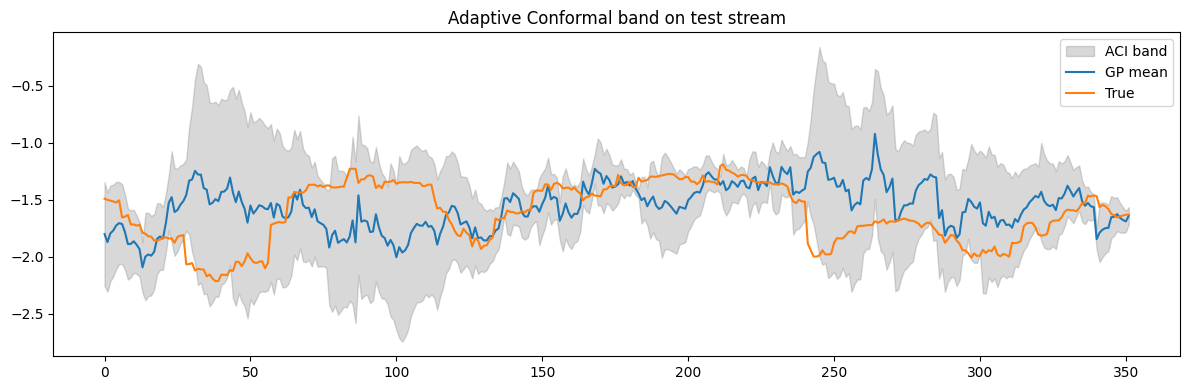

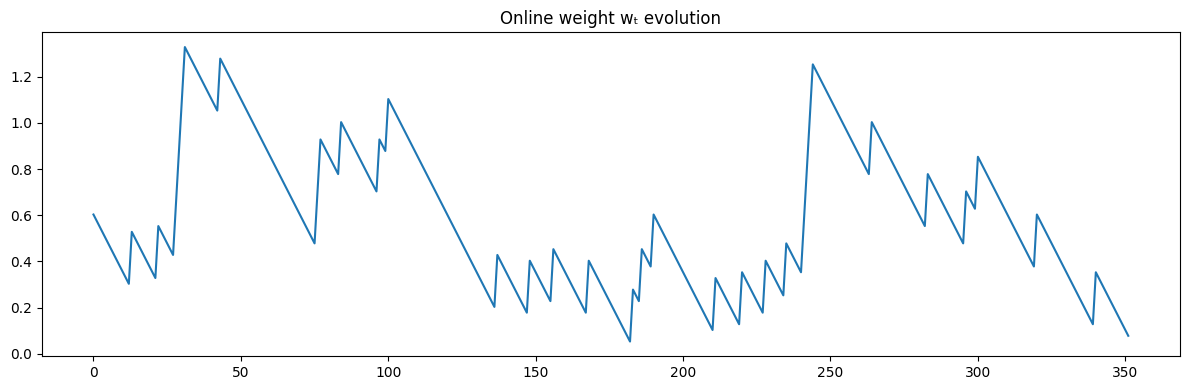

In [ ]:
y_arr = np.array(y_list);  mu_arr = np.array(mu_list)
lo_arr, hi_arr = np.array(lo_list), np.array(hi_list)

cov = np.mean((y_arr >= lo_arr) & (y_arr <= hi_arr))
mse_test = mean_squared_error(y_arr, mu_arr)
print(f"Test MSE = {mse_test:.6f}")
print(f"ACI coverage = {cov:.1%}  (target {(1-alpha):.0%})")

plt.figure(figsize=(12,4))
plt.fill_between(range(len(mu_arr)), lo_arr, hi_arr, color='gray', alpha=.3,
                 label='ACI band')
plt.plot(mu_arr, label='GP mean'); plt.plot(y_arr, label='True')
plt.title('Adaptive Conformal band on test stream'); plt.legend()
plt.tight_layout(); plt.show()

plt.figure(figsize=(12,4))
plt.plot(w_list); plt.title('Online weight wₜ evolution'); plt.tight_layout(); plt.show()


[GP observed] Test MSE (log):     0.110493
[GP observed] Test MAE (log):     0.200476
[GP observed] 90% coverage:       1.000
[GP observed] 90% avg width:      2.399331
[GP observed] 90% interval score: 2.399331
[GP observed] CRPS (log):         0.227874


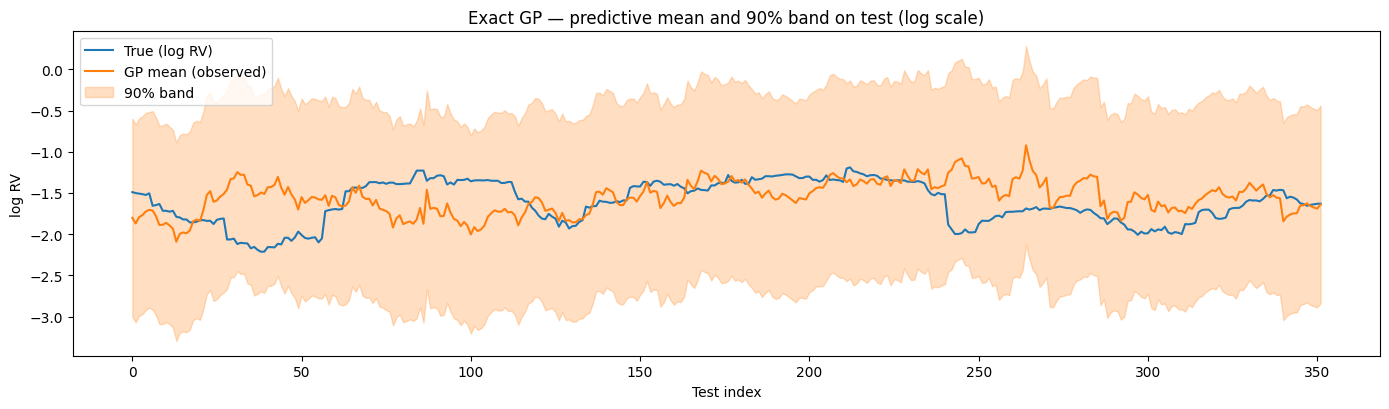

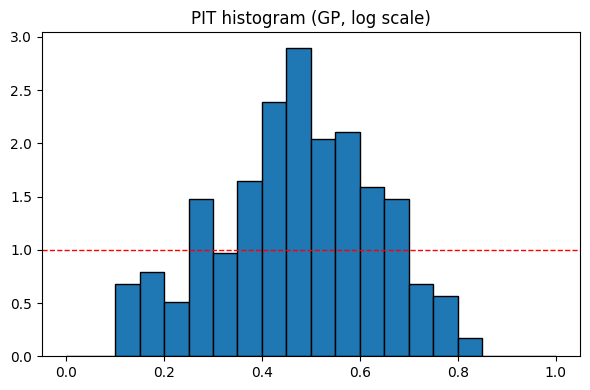

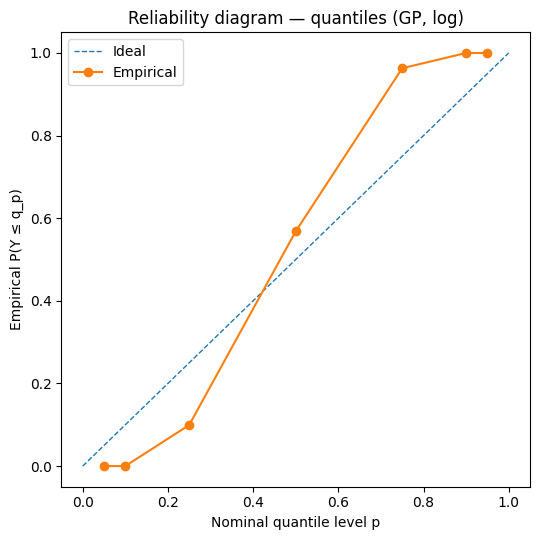

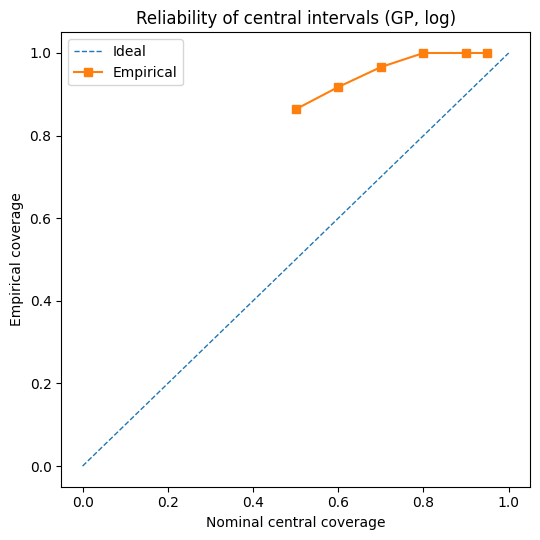

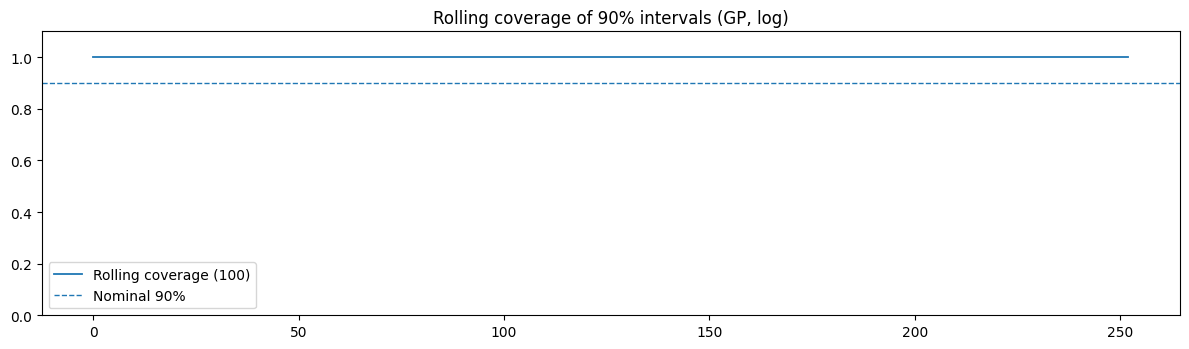

[Saved] plots/gp1/gp_exact_test_metrics_log.csv


In [ ]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, median_absolute_error
import torch, gpytorch, math, os
os.makedirs("plots", exist_ok=True)

USE_LATENT = False

def interval_score(alpha, l, u, y):
    width = u - l
    under = (l - y) if y < l else 0.0
    over  = (y - u) if y > u else 0.0
    return width + (2.0/alpha)*under + (2.0/alpha)*over

def crps_gaussian(y, mu, sig):
    """
    Closed-form CRPS for Normal(mu, sig^2).
    sig must be > 0 (on the SAME scale as y and mu).
    """
    from math import sqrt, pi, exp
    from scipy.stats import norm
    z = (y - mu) / (sig + 1e-12)
    return sig * ( z * (2*norm.cdf(z) - 1) + 2*norm.pdf(z) - 1/np.sqrt(np.pi) )

model.eval(); likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    if USE_LATENT:
        pred = model(X_test_t.to(device))              # latent f
    else:
        pred = likelihood(model(X_test_t.to(device)))  # observed y (includes noise)

mu_std = pred.mean.cpu().numpy().reshape(-1, 1)                    # standardized mean
sd_std = pred.variance.sqrt().cpu().numpy().reshape(-1, 1)         # standardized std

orig_scale = y_scaler.scale_[0]
orig_mean  = y_scaler.inverse_transform(mu_std).ravel()
orig_sd    = (sd_std * orig_scale).ravel()

y_true = y_scaler.inverse_transform(y_test_t.cpu().view(-1,1)).ravel()

# 90% band (Gaussian) 
alpha = 0.10
z90   = 1.6448536269514722  # Φ^{-1}(0.95)
lo90  = orig_mean - z90 * orig_sd
hi90  = orig_mean + z90 * orig_sd

#  Metrics (raw log scale) 
mse   = mean_squared_error(y_true, orig_mean)
mae = median_absolute_error(y_true, orig_mean)
cov90 = np.mean((y_true >= lo90) & (y_true <= hi90))
wid90 = np.mean(hi90 - lo90)
is90  = np.mean([interval_score(alpha, lo90[i], hi90[i], y_true[i]) for i in range(len(y_true))])

# CRPS (Gaussian, closed form)
try:
    from scipy.stats import norm  # used inside crps_gaussian
    crps_vals = crps_gaussian(y_true, orig_mean, np.maximum(orig_sd, 1e-12))
    crps = float(np.mean(crps_vals))
except Exception:
    # very light fallback if scipy is unavailable
    from math import sqrt, pi, exp
    def _norm_pdf(z): return (1/np.sqrt(2*np.pi)) * np.exp(-0.5*z*z)
    def _norm_cdf(z): return 0.5*(1+math.erf(z/np.sqrt(2)))
    z = (y_true - orig_mean) / np.maximum(orig_sd, 1e-12)
    crps = float(np.mean(orig_sd * ( z * (2*np.vectorize(_norm_cdf)(z) - 1)
                                     + 2*np.vectorize(_norm_pdf)(z) - 1/np.sqrt(np.pi) )))

print(f"[GP {'latent' if USE_LATENT else 'observed'}] Test MSE (log):     {mse:.6f}")
print(f"[GP {'latent' if USE_LATENT else 'observed'}] Test MAE (log):     {mae:.6f}")
print(f"[GP {'latent' if USE_LATENT else 'observed'}] 90% coverage:       {cov90:.3f}")
print(f"[GP {'latent' if USE_LATENT else 'observed'}] 90% avg width:      {wid90:.6f}")
print(f"[GP {'latent' if USE_LATENT else 'observed'}] 90% interval score: {is90:.6f}")
print(f"[GP {'latent' if USE_LATENT else 'observed'}] CRPS (log):         {crps:.6f}")

#  Test band plot 
x = np.arange(len(y_true))
plt.figure(figsize=(14,4.2))
plt.plot(x, y_true, label="True (log RV)")
plt.plot(x, orig_mean, label=f"GP mean ({'latent' if USE_LATENT else 'observed'})")
plt.fill_between(x, lo90, hi90, alpha=0.25, color="C1", label="90% band")
plt.title("Exact GP — predictive mean and 90% band on test (log scale)")
plt.xlabel("Test index"); plt.ylabel("log RV"); plt.legend(); plt.tight_layout()
plt.savefig("plots/gp1/gp_exact_test_band_log.png", dpi=160); plt.show()

#  Calibration diagnostics 

# PIT histogram (Gaussian PIT is analytic)
from scipy.stats import norm
pit = norm.cdf((y_true - orig_mean) / np.maximum(orig_sd, 1e-12))
plt.figure(figsize=(6,4))
plt.hist(pit, bins=20, range=(0,1), density=True, edgecolor="k")
plt.axhline(1.0, color="r", linestyle="--", linewidth=1.0)
plt.title("PIT histogram (GP, log scale)"); plt.tight_layout()
plt.savefig("plots/gp1/gp_exact_pit_hist.png", dpi=160); plt.show()

# Reliability diagram — quantiles
quantile_grid = np.array([0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])
empirical_ps = []
for p in quantile_grid:
    q = orig_mean + norm.ppf(p) * orig_sd
    empirical_ps.append(np.mean(y_true <= q))
empirical_ps = np.array(empirical_ps)

plt.figure(figsize=(5.5,5.5))
xx = np.linspace(0,1,201)
plt.plot(xx, xx, "--", lw=1.0, label="Ideal")
plt.plot(quantile_grid, empirical_ps, "o-", lw=1.5, label="Empirical")
plt.xlabel("Nominal quantile level p"); plt.ylabel("Empirical P(Y ≤ q_p)")
plt.title("Reliability diagram — quantiles (GP, log)"); plt.legend(); plt.tight_layout()
plt.savefig("plots/gp1/gp_exact_reliability_quantiles.png", dpi=160); plt.show()

# Reliability — central intervals
central_cover_grid = np.array([0.50, 0.60, 0.70, 0.80, 0.90, 0.95])
emp_covs = []
for c in central_cover_grid:
    a = (1-c)/2; b = 1 - a
    lo = orig_mean + norm.ppf(a) * orig_sd
    hi = orig_mean + norm.ppf(b) * orig_sd
    emp_covs.append(np.mean((y_true >= lo) & (y_true <= hi)))
emp_covs = np.array(emp_covs)

plt.figure(figsize=(5.5,5.5))
plt.plot(xx, xx, "--", lw=1.0, label="Ideal")
plt.plot(central_cover_grid, emp_covs, "s-", lw=1.5, label="Empirical")
plt.xlabel("Nominal central coverage"); plt.ylabel("Empirical coverage")
plt.title("Reliability of central intervals (GP, log)"); plt.legend(); plt.tight_layout()
plt.savefig("plots/gp1/gp_exact_reliability_intervals.png", dpi=160); plt.show()

# Rolling 90% coverage over time
win = 100
covered = ((y_true >= lo90) & (y_true <= hi90)).astype(float)
if len(covered) >= win:
    roll = np.convolve(covered, np.ones(win)/win, mode="valid")
    plt.figure(figsize=(12,3.6))
    plt.plot(roll, lw=1.3, label=f"Rolling coverage ({win})")
    plt.axhline(0.90, ls="--", lw=1.0, label="Nominal 90%")
    plt.ylim(0,1.1); plt.title("Rolling coverage of 90% intervals (GP, log)")
    plt.legend(); plt.tight_layout()
    plt.savefig("plots/gp1/gp_exact_coverage_by_time.png", dpi=160); plt.show()

# Save 
import pandas as pd
row = {
    "Model": f"Exact GP ({'latent' if USE_LATENT else 'observed'})",
    "MSE_log": mse,
    "MAE_log": mae,
    "CRPS_log": crps,
    "Coverage90": cov90,
    "AvgWidth90": wid90,
    "IntervalScore90": is90,
}
pd.DataFrame([row]).to_csv("plots/gp1/gp_exact_test_metrics_log.csv", index=False)
print("[Saved] plots/gp1/gp_exact_test_metrics_log.csv")


In [ ]:
model.eval(); likelihood.eval()
with torch.no_grad():
    pred_f = model(X_val_t)                    # latent
    pred_y = likelihood(model(X_val_t))        # observed

lat_std = pred_f.variance.sqrt().cpu().numpy().ravel()
obs_std = pred_y.variance.sqrt().cpu().numpy().ravel()

orig_scale = y_scaler.scale_[0]
print("noise var (stdz):", float(likelihood.noise.detach()))
print("noise std (orig):", float(likelihood.noise.sqrt().detach()) * orig_scale)
print("median latent std (orig):", np.median(lat_std) * orig_scale)
print("median observed std (orig):", np.median(obs_std) * orig_scale)


noise var (stdz): 0.4983690679073334
noise std (orig): 0.23213809596521617
median latent std (orig): 0.6840089462605401
median observed std (orig): 0.72232696827051


[ACI] q̂_(1-α) from validation: 0.628
[ACI lag 30] MSE(log)=0.110510  Coverage=0.903  Width=1.675158  Interval Score 90=2.039175


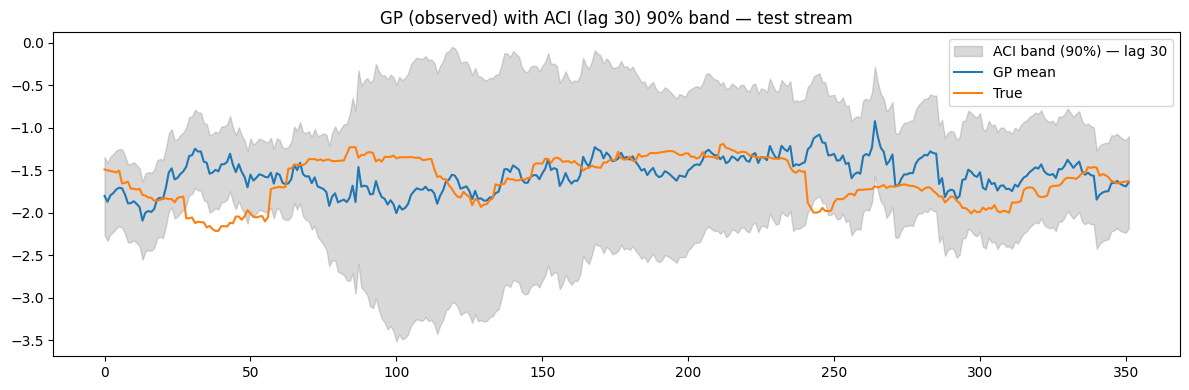

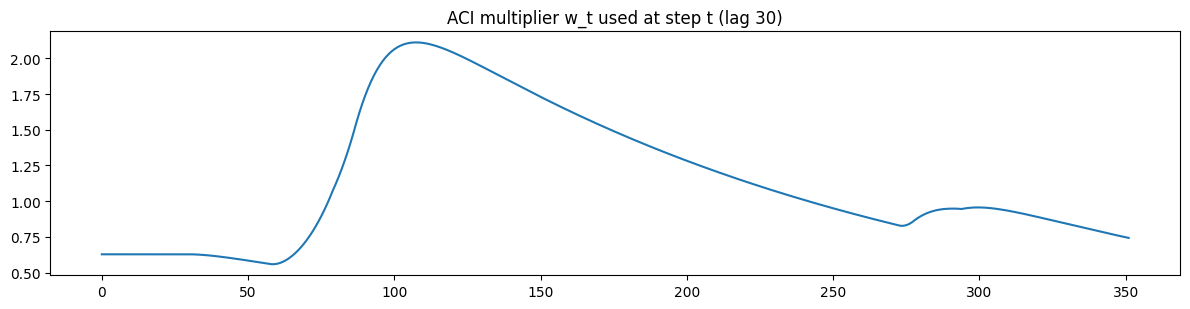

In [ ]:
import numpy as np, torch, gpytorch
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

alpha = 0.10           # 90% central interval
H     = 30             # horizon
beta  = 0.9           # EMA smoothing for misses (closer to 1 = smoother)
k     = 0.06           # multiplicative gain (try 0.05–0.12)
w_min = 0.05           # anti-windup lower bound
w_max = 5.0            # anti-windup upper bound
sd_floor = 1e-6        # protects against tiny std on raw scale

model.eval(); likelihood.eval()

def gp_mean_std_raw(x_t):
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        py = likelihood(model(x_t.to(device)))
        mu_std = py.mean.cpu().numpy().reshape(-1, 1)
        sd_std = py.variance.sqrt().cpu().numpy().reshape(-1, 1)
    mu_raw = y_scaler.inverse_transform(mu_std).ravel()
    sd_raw = (sd_std * y_scaler.scale_[0]).ravel()
    return mu_raw, sd_raw

#  Init w on validation (split-conformal) 
mu_val_raw, sd_val_raw = gp_mean_std_raw(X_val_t)
y_val_raw = y_scaler.inverse_transform(y_val_t.cpu().view(-1,1)).ravel()
scores    = np.abs(y_val_raw - mu_val_raw) / np.maximum(sd_val_raw, sd_floor)
w0        = float(np.quantile(scores[np.isfinite(scores)], 1 - alpha))
print(f"[ACI] q̂_(1-α) from validation: {w0:.3f}")

#  Allocate 
n_te = len(X_test_t)
y_test_raw = y_scaler.inverse_transform(y_test_t.cpu().view(-1,1)).ravel()

mu_arr = np.full(n_te, np.nan)
sd_arr = np.full(n_te, np.nan)
lo_arr = np.full(n_te, np.nan)
hi_arr = np.full(n_te, np.nan)
w_used = np.full(n_te, np.nan)

w = np.clip(w0, w_min, w_max)
miss_ema = alpha  # start neutral

# ----- Online loop with lagged updates -----
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    for i in range(n_te):
        py  = likelihood(model(X_test_t[i:i+1].to(device)))
        mu  = y_scaler.inverse_transform(py.mean.cpu().numpy().reshape(-1,1))[0,0]
        sd  = float(py.variance.sqrt().cpu().item() * y_scaler.scale_[0])
        sd  = max(sd, sd_floor)

        mu_arr[i] = mu; sd_arr[i] = sd
        lo_arr[i] = mu - w * sd
        hi_arr[i] = mu + w * sd
        w_used[i] = w

        j = i - H
        if j >= 0:
            yj   = y_test_raw[j]
            miss = 0.0 if (lo_arr[j] <= yj <= hi_arr[j]) else 1.0
            miss_ema = beta * miss_ema + (1 - beta) * miss
            w = w * np.exp(k * (miss_ema - alpha))
            w = float(np.clip(w, w_min, w_max))

# Metrics  
mask = np.isfinite(mu_arr) & np.isfinite(lo_arr) & np.isfinite(hi_arr) & np.isfinite(y_test_raw)
y_arr  = y_test_raw[mask]; mu_eff = mu_arr[mask]
lo_eff = lo_arr[mask];     hi_eff = hi_arr[mask]

def interval_score(alpha, l, u, y):
    width = u - l
    under = (l - y) if y < l else 0.0
    over  = (y - u) if y > u else 0.0
    return width + (2.0/alpha)*under + (2.0/alpha)*over

cov  = np.mean((y_arr >= lo_eff) & (y_arr <= hi_eff))
wid  = np.mean(hi_eff - lo_eff)
mse  = mean_squared_error(y_arr, mu_eff)
is90 = np.mean([interval_score(alpha, lo_eff[k], hi_eff[k], y_arr[k]) for k in range(len(y_arr))])

print(f"[ACI lag {H}] MSE(log)={mse:.6f}  Coverage={cov:.3f}  Width={wid:.6f}  Interval Score 90={is90:.6f}")

#  Plots 
x = np.arange(n_te)
plt.figure(figsize=(12,4))
plt.fill_between(x, lo_arr, hi_arr, color='gray', alpha=.3, label=f'ACI band (90%) — lag {H}')
plt.plot(mu_arr, label='GP mean'); plt.plot(y_test_raw, label='True')
plt.title(f'GP (observed) with ACI (lag {H}) 90% band — test stream'); plt.legend()
plt.savefig(f"plots/gp1/gp_aci_test_band_log.png", dpi=160)
plt.tight_layout(); plt.show()

plt.figure(figsize=(12,3.2))
plt.plot(w_used); plt.title(f'ACI multiplier w_t used at step t (lag {H})')
plt.tight_layout(); plt.show()


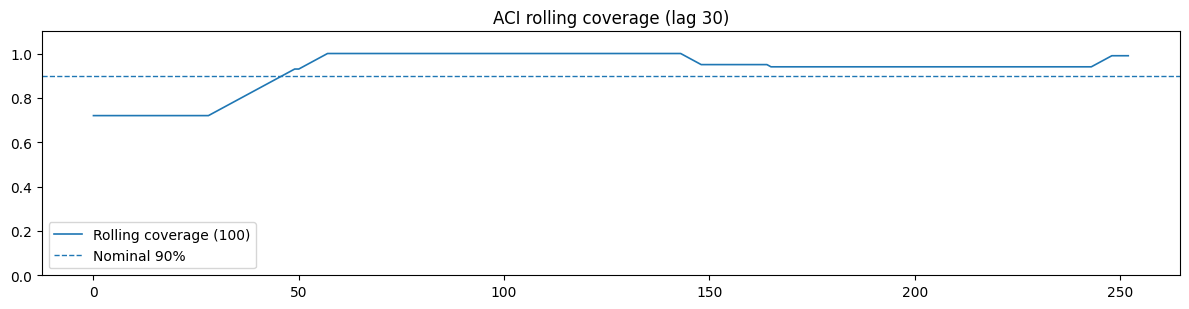

w0 (from val): 0.628
w_used mean:   1.148  median: 0.956  last: 0.743
[Saved] plots/gp1/gp_aci_test_metrics_log.csv


In [ ]:
win = 100
covered = ((y_arr >= lo_eff) & (y_arr <= hi_eff)).astype(float)
if len(covered) >= win:
    roll = np.convolve(covered, np.ones(win)/win, mode="valid")
    plt.figure(figsize=(12,3.2))
    plt.plot(roll, lw=1.2, label=f"Rolling coverage ({win})")
    plt.axhline(0.90, ls="--", lw=1.0, label="Nominal 90%")
    plt.ylim(0,1.1); plt.legend(); plt.title("ACI rolling coverage (lag 30)")
    plt.savefig("plots/gp1/gp_aci_coverage_by_time.png", dpi=160)
    plt.tight_layout(); plt.show()

print(f"w0 (from val): {w0:.3f}")
print(f"w_used mean:   {np.nanmean(w_used):.3f}  median: {np.nanmedian(w_used):.3f}  last: {w_used[~np.isnan(w_used)][-1]:.3f}")

import pandas as pd, os
os.makedirs("plots", exist_ok=True)
row = {
    "Model": "GP + ACI (lag 30)",
    "H": 30, "beta": 0.9, "k": 0.06, "w0": w0,
    "MSE_log": mse, "Coverage90": cov, "AvgWidth90": wid, "IntervalScore90": is90
}
pd.DataFrame([row]).to_csv("plots/gp1/gp_aci_test_metrics_log.csv", index=False)
print("[Saved] plots/gp1/gp_aci_test_metrics_log.csv")
